In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib 

devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4794248033172540609
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3792014249988860031
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8066902874800692424
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8327072087123730964
physical_device_desc: "device: XLA_GPU device"
]


# 准备数据集
## 加载数据集

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../dataset/", one_hot=True)
print("train dataset: image shape: {}, label: shape: {}".format(
    mnist.train.images.shape,
    mnist.train.labels.shape,
))

print("test dataset: image shape: {}, label: shape: {}".format(
    mnist.test.images.shape,
    mnist.test.labels.shape,
))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../dataset/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../dataset/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../dataset/t10k-images-idx3-ubyte.gz
Extracting ../dataset/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
train dataset: image shape: (55000, 784), label: shape: (55000, 10)
test dataset: image shape: (10000, 784), label: shape: (10000, 10)


## 数据展示

label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


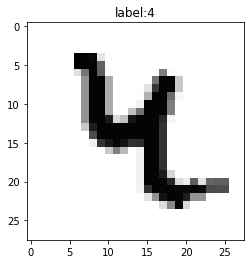

In [3]:
print('label:', mnist.train.labels[32])
label = np.argmax(mnist.train.labels[32])  # The largested value (where 1 exists)
im = np.reshape(mnist.train.images[32], [28,28])
plt.imshow(im, cmap='Greys')
plt.title('label:' + str(label))
plt.show()

# 定义模型

## 定义初始化方法和基础算子

In [4]:
""" Initialize weight """
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

""" Initialize bias """ 
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

""" Define convolution """
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

""" Define pooling """
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

## 搭建模型

In [5]:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, [None, 784])
    y_true = tf.placeholder(tf.float32, [None, 10])
    # reshape
    x_image = tf.reshape(x, [-1,28,28,1])
    # 卷积层 1， weight和bias
    W_conv1 = weight_variable([5, 5, 1, 32])  
    b_conv1 = bias_variable([32])
    # 卷积操作 1
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    # 池化操作 1
    h_pool1 = max_pool_2x2(h_conv1)
    # 卷积层 2， weight和bias
    W_conv2 = weight_variable([5, 5, 32, 64]) 
    b_conv2 = bias_variable([64])
    # 卷积操作 2
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    # 池化操作 2
    h_pool2 = max_pool_2x2(h_conv2)
    # 全连接层， weight和bias
    W_fc1 = weight_variable([7 * 7 * 64, 1024])  
    b_fc1 = bias_variable([1024])
    # 全连接操作
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    # drop out
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    # 全连接 2
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])
    y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# 训练和验证
## 损失函数、优化器、指标

In [6]:
with g.as_default():
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(y_conv), reduction_indices=[1]))
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_true,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 启动训练

step 0, training accuracy 0.05999999865889549
step 100, training accuracy 0.8899999856948853
step 200, training accuracy 0.8500000238418579
step 300, training accuracy 0.9700000286102295
step 400, training accuracy 0.8600000143051147
test accuracy 0.9539999961853027
2


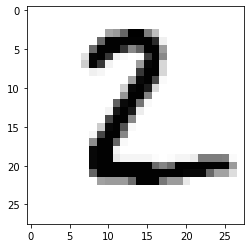

: 

In [7]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    # Sample every 100 pieces of data to perform learning 2000 times.
    for i in range(500):
        batch = mnist.train.next_batch(100)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x: batch[0], y_true: batch[1], keep_prob: 1.0})
            print('step {}, training accuracy {}'.format(i, train_accuracy))
        optimizer.run(feed_dict={x: batch[0], y_true: batch[1], keep_prob: 0.5})

    print('test accuracy {}'.format(accuracy.eval(feed_dict={
        x: mnist.test.images, y_true: mnist.test.labels, keep_prob: 1.0})))
    
    plt.imshow(mnist.test.images[1].reshape(28,28), cmap='Greys')
    print(np.argmax(y_conv.eval(feed_dict={x:mnist.test.images[1].reshape(1,784), y_true:mnist.test.labels[1].reshape(1, 10), keep_prob:1.0})))